Импортируем необходимые библиотеки

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.weightstats import ztest

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn import metrics

# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

##  Отбираем данные

Скачиваем угнанную с https://www.kaggle.com/datasets/carolzhangdc/imdb-5000-movie-dataset таблицу

In [2]:
df = pd.read_csv('data/movie_metadata.csv', sep=',')
df

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


В ней куча различной странной информации - посмотрим все колонки и оставим только нужное:

In [3]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [4]:
df = df[['movie_title', 'title_year', 'director_name', 'actor_1_name', 'actor_2_name', 
         'genres', 'language', 'country', 'budget', 'gross', 'imdb_score', 'duration',
         'content_rating', 'color']]
df

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
0,Avatar,2009.0,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000.0,760505847.0,7.9,178.0,PG-13,Color
1,Pirates of the Caribbean: At World's End,2007.0,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000.0,309404152.0,7.1,169.0,PG-13,Color
2,Spectre,2015.0,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000.0,200074175.0,6.8,148.0,PG-13,Color
3,The Dark Knight Rises,2012.0,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000.0,448130642.0,8.5,164.0,PG-13,Color
4,Star Wars: Episode VII - The Force Awakens ...,NaN,Doug Walker,Doug Walker,Rob Walker,Documentary,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Signed Sealed Delivered,2013.0,Scott Smith,Eric Mabius,Daphne Zuniga,Comedy|Drama,English,Canada,NaN,NaN,7.7,87.0,NaN,Color
5039,The Following,NaN,NaN,Natalie Zea,Valorie Curry,Crime|Drama|Mystery|Thriller,English,USA,NaN,NaN,7.5,43.0,TV-14,Color
5040,A Plague So Pleasant,2013.0,Benjamin Roberds,Eva Boehnke,Maxwell Moody,Drama|Horror|Thriller,English,USA,1400.0,NaN,6.3,76.0,NaN,Color
5041,Shanghai Calling,2012.0,Daniel Hsia,Alan Ruck,Daniel Henney,Comedy|Drama|Romance,English,USA,NaN,10443.0,6.3,100.0,PG-13,Color


Где:

'movie_title' - название фильма

'title_year' - год выпуска фильма

'director_name' - имя режиссера 

'actor_1_name' - имя актера в главной роли

'actor_2_name' - имя актера во второй главной роли

'genres' - жанры фильма

'language' - оригнальный язык фильма

'country' - страна-производитель фильма

'budget' - бюджет фильма 

'gross' - сборы фильма в США

'imdb_score' - оценка портала IMDB

'duration' - продолжительность фильма в минутах

'content_rating' - возрастное ограничение

'color' - цвет картинки фильма (цветной или ч/б)

В первый раз посмотрим на пропуски в данных:

In [5]:
df.isnull().sum()

movie_title         0
title_year        108
director_name     104
actor_1_name        7
actor_2_name       13
genres              0
language           12
country             5
budget            492
gross             884
imdb_score          0
duration           15
content_rating    303
color              19
dtype: int64

Видим много пропусков в колонках 'gross' и 'budget': колонки 'gross' и 'budget' - это важные данные, с ними будем активно работать в дальнейшем, удалим данные с NaN в них, тк заменить нечем.


In [6]:
df.dropna(subset=['budget', 'gross', 'duration'], inplace=True)
df

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
0,Avatar,2009.0,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000.0,760505847.0,7.9,178.0,PG-13,Color
1,Pirates of the Caribbean: At World's End,2007.0,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000.0,309404152.0,7.1,169.0,PG-13,Color
2,Spectre,2015.0,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000.0,200074175.0,6.8,148.0,PG-13,Color
3,The Dark Knight Rises,2012.0,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000.0,448130642.0,8.5,164.0,PG-13,Color
5,John Carter,2012.0,Andrew Stanton,Daryl Sabara,Samantha Morton,Action|Adventure|Sci-Fi,English,USA,263700000.0,73058679.0,6.6,132.0,PG-13,Color
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,Primer,2004.0,Shane Carruth,Shane Carruth,David Sullivan,Drama|Sci-Fi|Thriller,English,USA,7000.0,424760.0,7.0,77.0,PG-13,Color
5034,Cavite,2005.0,Neill Dela Llana,Ian Gamazon,Edgar Tancangco,Thriller,English,Philippines,7000.0,70071.0,6.3,80.0,Not Rated,Color
5035,El Mariachi,1992.0,Robert Rodriguez,Carlos Gallardo,Peter Marquardt,Action|Crime|Drama|Romance|Thriller,Spanish,USA,7000.0,2040920.0,6.9,81.0,R,Color
5037,Newlyweds,2011.0,Edward Burns,Kerry Bishé,Caitlin FitzGerald,Comedy|Drama,English,USA,9000.0,4584.0,6.4,95.0,Not Rated,Color


Теперь еще раз взглянем на наши данные:

In [7]:
df.isnull().sum()

movie_title        0
title_year         0
director_name      0
actor_1_name       3
actor_2_name       5
genres             0
language           3
country            0
budget             0
gross              0
imdb_score         0
duration           0
content_rating    50
color              2
dtype: int64

Стало гораздо лучше! В данных все еще встречаются пропуски, однако пока они не будут нам мешать, вернемся к ним позже.

Проверим дублирующиеся данные:

In [8]:
df.duplicated().sum()

101

И удалим их

In [9]:
df.drop_duplicates(inplace=True)
df

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
0,Avatar,2009.0,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000.0,760505847.0,7.9,178.0,PG-13,Color
1,Pirates of the Caribbean: At World's End,2007.0,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000.0,309404152.0,7.1,169.0,PG-13,Color
2,Spectre,2015.0,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000.0,200074175.0,6.8,148.0,PG-13,Color
3,The Dark Knight Rises,2012.0,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000.0,448130642.0,8.5,164.0,PG-13,Color
5,John Carter,2012.0,Andrew Stanton,Daryl Sabara,Samantha Morton,Action|Adventure|Sci-Fi,English,USA,263700000.0,73058679.0,6.6,132.0,PG-13,Color
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,Primer,2004.0,Shane Carruth,Shane Carruth,David Sullivan,Drama|Sci-Fi|Thriller,English,USA,7000.0,424760.0,7.0,77.0,PG-13,Color
5034,Cavite,2005.0,Neill Dela Llana,Ian Gamazon,Edgar Tancangco,Thriller,English,Philippines,7000.0,70071.0,6.3,80.0,Not Rated,Color
5035,El Mariachi,1992.0,Robert Rodriguez,Carlos Gallardo,Peter Marquardt,Action|Crime|Drama|Romance|Thriller,Spanish,USA,7000.0,2040920.0,6.9,81.0,R,Color
5037,Newlyweds,2011.0,Edward Burns,Kerry Bishé,Caitlin FitzGerald,Comedy|Drama,English,USA,9000.0,4584.0,6.4,95.0,Not Rated,Color


Косметическое изменение для удобства восприятия информации - уберем дробную часть у чисел, которым она не нужна:

In [10]:
df[['budget', 'gross', 'title_year', 'duration']] = df[['budget', 'gross', 'title_year', 'duration']].astype(int)


Также отбрем фильмы выпущенные хотя бы начиная с 2003 года (для не катастрафического расхождения в стоимости относительно других фильмов) и с бюджетом хотя бы 5 млн $, тк включение в дальнейший анализ фильмов, снятых за 'пачку сухариков' по меркам мирового кино (меньшую сумму), неминуемо приведет нас либо к порогу окупаемости, либо к статистическим выбросам. 


In [11]:
df_good = df[df['budget'] >= 5000000][df['title_year'] >= 2003]
df_good

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
0,Avatar,2009,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000,760505847,7.9,178,PG-13,Color
1,Pirates of the Caribbean: At World's End,2007,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000,309404152,7.1,169,PG-13,Color
2,Spectre,2015,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000,200074175,6.8,148,PG-13,Color
3,The Dark Knight Rises,2012,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000,448130642,8.5,164,PG-13,Color
5,John Carter,2012,Andrew Stanton,Daryl Sabara,Samantha Morton,Action|Adventure|Sci-Fi,English,USA,263700000,73058679,6.6,132,PG-13,Color
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,God's Not Dead 2,2016,Harold Cronk,Benjamin A. Onyango,Robin Givens,Drama,English,USA,5000000,20773070,3.4,120,PG,Color
4551,The Green Inferno,2013,Eli Roth,Daryl Sabara,Richard Burgi,Adventure|Horror,English,USA,6000000,7186670,5.4,100,R,Color
4789,As It Is in Heaven,2004,Kay Pollak,Michael Nyqvist,Frida Hallgren,Comedy|Drama|Music|Romance,Swedish,Sweden,25000000,9910,7.6,133,NaN,Color
4804,What Happens in Vegas,2008,Tom Vaughan,Treat Williams,Andrew Daly,Comedy|Romance,English,USA,35000000,80276912,6.1,101,PG-13,Color


### Отвлекаемся на плохие данные

Дело в том, что в мировом кино достаточно проблематично выпустить полноценный фильм, хоть даже и являющийся по факту "франкенштейном" из короткометражек, без поддержки какой-либо студии. Иначе, невозможно гарантировать своему проекту достаточное количество экранов как на главном кинорынке мира - США, так и по всему миру, а значит - невозможно и говорить о получении прибыли и планировании стратегии окупаемости фильма, что, конечно, выбивается из идеальных предпосылок нашего анализа. Сами студии редко спонсируют или берут в разработку проекты с таким маленьким бюджетом из-за риска не заинтересовать зрителя ни картинкой, ни узнаваемыми лицами, а значит не получить прибыль вовсе. Ведь чтобы получить оценки за фильм, сначала необходимо зрителю этот фильм продать. Поэтому низкобюджетные фильмы зачастую либо надеются на чудо, либо являются своеобразными аттестационными работами в "большое кино", больше показывающие умение человека работать, а не зарабатывать рекордные деньги. Окупившийся в нынешнем прокате даже в 20 раз (не говоря о том, что обычно они едва ли окупаются) низкобюджетный фильм принесет студии гораздо меньше, чем 3 раза окупившийся блокбастер (который, к тому же, гарантированно привлечет зрителей). Уже давно по очевидным причинам крупные студии не делают ставку на низкобюджетные фильмы, но все так же в первую очередь смотрят на окупаемость фильма, а значит статистика по фильмам с низким бюджетом не только не будет востребована, но и будет сбивать нас с толку.

Давайте увидим это, используя наши отброшенные данные. Оставляем фильмы после 2003 для все той же корректировки стоимости, но на этот раз фиксируем максимальную планку бюджета на уровне 5 млн $:

In [12]:
df_bad = df[df['budget'] < 5000000][df['title_year'] >= 2003]
df_bad

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
2120,Hit and Run,2012,David Palmer,Bradley Cooper,Tom Arnold,Action|Comedy|Romance,English,USA,2000000,13746550,6.1,100,R,Color
2326,The Proposition,2005,John Hillcoat,Ray Winstone,Noah Taylor,Crime|Drama|Western,English,Australia,2000000,1900725,7.4,104,R,Color
2511,Larry the Cable Guy: Health Inspector,2006,Trent Cooper,Thomas F. Wilson,Larry the Cable Guy,Comedy|Romance,English,USA,4000000,15655665,3.1,89,PG-13,Color
3224,Imaginary Heroes,2004,Dan Harris,Kip Pardue,Ryan Donowho,Comedy|Drama,English,USA,4000000,228524,7.3,111,R,Color
3440,An Education,2009,Lone Scherfig,Dominic Cooper,Olivia Williams,Drama,English,UK,4500000,12574715,7.3,100,PG-13,Color
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,Clean,2004,Olivier Assayas,Maggie Cheung,Béatrice Dalle,Drama|Music|Romance,French,France,4500,136007,6.9,110,R,Color
5033,Primer,2004,Shane Carruth,Shane Carruth,David Sullivan,Drama|Sci-Fi|Thriller,English,USA,7000,424760,7.0,77,PG-13,Color
5034,Cavite,2005,Neill Dela Llana,Ian Gamazon,Edgar Tancangco,Thriller,English,Philippines,7000,70071,6.3,80,Not Rated,Color
5037,Newlyweds,2011,Edward Burns,Kerry Bishé,Caitlin FitzGerald,Comedy|Drama,English,USA,9000,4584,6.4,95,Not Rated,Color


Создадим колонку 'profitability', которая будет показывать во сколько раз окупился фильм:

In [13]:
df_bad['profitability'] = df_bad['gross'] / df_bad['budget'] 
df_bad

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color,profitability
2120,Hit and Run,2012,David Palmer,Bradley Cooper,Tom Arnold,Action|Comedy|Romance,English,USA,2000000,13746550,6.1,100,R,Color,6.873275
2326,The Proposition,2005,John Hillcoat,Ray Winstone,Noah Taylor,Crime|Drama|Western,English,Australia,2000000,1900725,7.4,104,R,Color,0.950362
2511,Larry the Cable Guy: Health Inspector,2006,Trent Cooper,Thomas F. Wilson,Larry the Cable Guy,Comedy|Romance,English,USA,4000000,15655665,3.1,89,PG-13,Color,3.913916
3224,Imaginary Heroes,2004,Dan Harris,Kip Pardue,Ryan Donowho,Comedy|Drama,English,USA,4000000,228524,7.3,111,R,Color,0.057131
3440,An Education,2009,Lone Scherfig,Dominic Cooper,Olivia Williams,Drama,English,UK,4500000,12574715,7.3,100,PG-13,Color,2.794381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,Clean,2004,Olivier Assayas,Maggie Cheung,Béatrice Dalle,Drama|Music|Romance,French,France,4500,136007,6.9,110,R,Color,30.223778
5033,Primer,2004,Shane Carruth,Shane Carruth,David Sullivan,Drama|Sci-Fi|Thriller,English,USA,7000,424760,7.0,77,PG-13,Color,60.680000
5034,Cavite,2005,Neill Dela Llana,Ian Gamazon,Edgar Tancangco,Thriller,English,Philippines,7000,70071,6.3,80,Not Rated,Color,10.010143
5037,Newlyweds,2011,Edward Burns,Kerry Bishé,Caitlin FitzGerald,Comedy|Drama,English,USA,9000,4584,6.4,95,Not Rated,Color,0.509333


Посмотрим на распределение значений окупаемости:

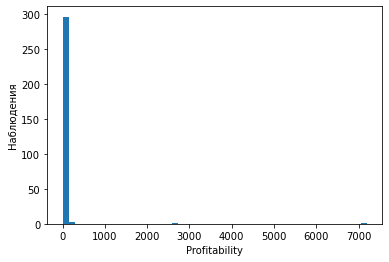

In [14]:
plt.hist(df_bad['profitability'], bins=50)
plt.ylabel('Наблюдения', fontsize=10)
plt.xlabel('Profitability', fontsize=10);

Видим очень страшные выбросы около 3000 и 7000, давайте разберемся в чем здесь дело. Посмотрим на 30 самых больших значений окупаемости:

In [15]:
df_bad['profitability'].sort_values(ascending=False).head(30)

4793    7194.485533
4799    2715.660550
4956     227.578190
4977     177.374892
4791     111.352390
4955     101.746630
5042      77.474545
4723      66.902958
4726      61.001764
5033      60.680000
4545      53.245055
4931      52.432961
4485      45.961169
4413      35.994091
4534      31.537320
5026      30.223778
4052      28.249961
4735      24.507196
4356      22.772253
3697      21.756273
4058      21.474550
4538      18.112929
4645      17.886491
4260      17.261111
4059      16.018980
4180      16.016673
4659      14.196984
4864      13.552840
4181      13.339980
4926      13.160740
Name: profitability, dtype: float64

Достанем самые выдающиеся:

In [16]:
df_bad.loc[[4793, 4799]]

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color,profitability
4793,Paranormal Activity,2007,Oren Peli,Micah Sloat,Ashley Palmer,Horror,English,USA,15000,107917283,6.3,84,R,Color,7194.485533
4799,Tarnation,2003,Jonathan Caouette,Greg Ayres,Jonathan Caouette,Biography|Documentary,English,USA,218,592014,7.2,88,Unrated,Color,2715.660550


Что же мы видим: 

> Paranormal Activity - оно же паранормальное явление, феномен киноиндустрии, который до сих пор мотивирует людей снимать псевдодокументальные картины. За ним последовало огромное количество картин такого жанра, однако ни одна из этих картин не повторила кассового успеха оригинала. Настоящее чудо, не поддающееся статистическому анализу. К тому же, к времени выхода картины на экраны бюджет уже стал гораздо больше из-за вмешательства студии (даже концовку пересняли, подробнее можно прочитать тут: https://en.wikipedia.org/wiki/Paranormal_Activity)

> Tarnation или проклятие в нашей адаптации - фильм, который снимали целых 24 года на домашнюю камеру и монтировали в iMovie, показавший космические цифры окупаемости, однако заработавший в США чуть меньше 600 тыс $. В чем дело? - в 218 долларах бюджета! Больше похоже на какую-то шутку (не познавательная, но занимательная история тут: https://ru.wikipedia.org/wiki/Проклятие_(фильм,_2003))

Такие наблюдения и подобные им будут только портить наш анализ, поэтому от них необходимо избавляться.

Уберем слишком откровенные выбросы:

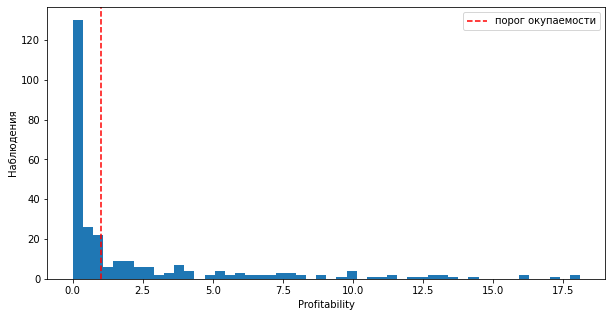

In [17]:
plt.figure(figsize=(10,5))
plt.hist(df_bad[df_bad['profitability'] <= 20]['profitability'], bins=50)
plt.ylabel('Наблюдения', fontsize=10)
plt.xlabel('Profitability', fontsize=10)
plt.axvline(x=1, color='red', linestyle='--', label='порог окупаемости')
plt.legend(loc='upper right',fontsize=10);

Как и было сказано выше, большинство малобюджетных фильмов даже не переваливают за порог окупаемости = 1. Не окупающиеся фильмы никто не захочет снимать, значит в таблице для дальнейшего анализа этим наблюдениям делать нечего.

### Возвращаемся к отобранным данным

In [18]:
df_good

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color
0,Avatar,2009,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000,760505847,7.9,178,PG-13,Color
1,Pirates of the Caribbean: At World's End,2007,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000,309404152,7.1,169,PG-13,Color
2,Spectre,2015,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000,200074175,6.8,148,PG-13,Color
3,The Dark Knight Rises,2012,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000,448130642,8.5,164,PG-13,Color
5,John Carter,2012,Andrew Stanton,Daryl Sabara,Samantha Morton,Action|Adventure|Sci-Fi,English,USA,263700000,73058679,6.6,132,PG-13,Color
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,God's Not Dead 2,2016,Harold Cronk,Benjamin A. Onyango,Robin Givens,Drama,English,USA,5000000,20773070,3.4,120,PG,Color
4551,The Green Inferno,2013,Eli Roth,Daryl Sabara,Richard Burgi,Adventure|Horror,English,USA,6000000,7186670,5.4,100,R,Color
4789,As It Is in Heaven,2004,Kay Pollak,Michael Nyqvist,Frida Hallgren,Comedy|Drama|Music|Romance,Swedish,Sweden,25000000,9910,7.6,133,NaN,Color
4804,What Happens in Vegas,2008,Tom Vaughan,Treat Williams,Andrew Daly,Comedy|Romance,English,USA,35000000,80276912,6.1,101,PG-13,Color


По аналогии с "плохими" данными создаем новую колонку "profitability", которая будет показывать во сколько раз окупился фильм:

In [19]:
df_good['profitability'] = df_good['gross'] / df_good['budget']
df_good

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color,profitability
0,Avatar,2009,James Cameron,CCH Pounder,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000,760505847,7.9,178,PG-13,Color,3.208885
1,Pirates of the Caribbean: At World's End,2007,Gore Verbinski,Johnny Depp,Orlando Bloom,Action|Adventure|Fantasy,English,USA,300000000,309404152,7.1,169,PG-13,Color,1.031347
2,Spectre,2015,Sam Mendes,Christoph Waltz,Rory Kinnear,Action|Adventure|Thriller,English,UK,245000000,200074175,6.8,148,PG-13,Color,0.816629
3,The Dark Knight Rises,2012,Christopher Nolan,Tom Hardy,Christian Bale,Action|Thriller,English,USA,250000000,448130642,8.5,164,PG-13,Color,1.792523
5,John Carter,2012,Andrew Stanton,Daryl Sabara,Samantha Morton,Action|Adventure|Sci-Fi,English,USA,263700000,73058679,6.6,132,PG-13,Color,0.277052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,God's Not Dead 2,2016,Harold Cronk,Benjamin A. Onyango,Robin Givens,Drama,English,USA,5000000,20773070,3.4,120,PG,Color,4.154614
4551,The Green Inferno,2013,Eli Roth,Daryl Sabara,Richard Burgi,Adventure|Horror,English,USA,6000000,7186670,5.4,100,R,Color,1.197778
4789,As It Is in Heaven,2004,Kay Pollak,Michael Nyqvist,Frida Hallgren,Comedy|Drama|Music|Romance,Swedish,Sweden,25000000,9910,7.6,133,NaN,Color,0.000396
4804,What Happens in Vegas,2008,Tom Vaughan,Treat Williams,Andrew Daly,Comedy|Romance,English,USA,35000000,80276912,6.1,101,PG-13,Color,2.293626


Посмотрим на распределение значений окупаемости:

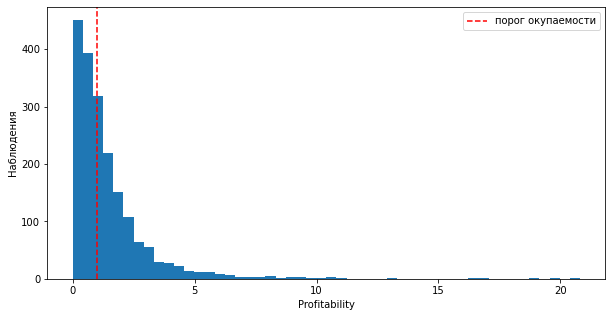

In [20]:
plt.figure(figsize=(10,5))
plt.hist(df_good['profitability'], bins=50)
plt.ylabel('Наблюдения', fontsize=10)
plt.xlabel('Profitability', fontsize=10)
plt.axvline(x=1, color='red', linestyle='--', label='порог окупаемости')
plt.legend(loc='upper right',fontsize=10);

Распределение гораздо приятнее, чем в прошлом пункте. За счет более высоких бюджетов, окупаемость гораздо меньше сбивает нас с толку. В данной выборке гораздо больше фильмов переходят порог окупаемости = 1. Можно также посмотреть на выбросы.

In [21]:
df_good['profitability'].sort_values(ascending=False).head(30)

3701    20.801566
3583    19.846399
3463    19.132379
3696    16.714966
3470    16.244285
3797    13.013828
3554    12.963667
3103    11.017587
3706    10.776964
3099    10.538587
2947    10.405736
3702    10.164188
4024     9.676627
2762     9.421280
2607     9.253023
3670     9.160387
3705     8.891302
1403     8.825875
3158     8.754258
3193     8.393438
2391     8.336472
3028     8.232400
2835     8.227102
3091     8.015034
3288     7.946581
1397     7.923239
3094     7.884513
2921     7.628934
3016     7.620271
3361     7.486243
Name: profitability, dtype: float64

In [22]:
df_good.loc[[3701, 3583, 3463, 3696, 3470]]

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color,profitability
3701,Paranormal Activity 3,2011,Henry Joost,Johanna Braddy,Sprague Grayden,Horror,English,USA,5000000,104007828,5.8,94,R,Color,20.801566
3583,Fahrenheit 9/11,2004,Michael Moore,Osama bin Laden,Stevie Wonder,Documentary|Drama|War,English,USA,6000000,119078393,7.5,122,R,Color,19.846399
3463,Juno,2007,Jason Reitman,J.K. Simmons,Jennifer Garner,Comedy|Drama|Romance,English,USA,7500000,143492840,7.5,96,PG-13,Color,19.132379
3696,Insidious: Chapter 2,2013,James Wan,Lin Shaye,Barbara Hershey,Fantasy|Horror|Thriller,English,USA,5000000,83574831,6.6,106,PG-13,Color,16.714966
3470,Magic Mike,2012,Steven Soderbergh,Channing Tatum,Alex Pettyfer,Comedy|Drama,English,USA,7000000,113709992,6.1,110,R,Color,16.244285


Заметим, что высокую окупаемость, ожидаемо, показывают фильмы с низким бюджетом.

### Теперь посмотрим на другие признаки.

Посмотрим на то, в каких странах cнимают большее количество высокобюджетных фильмов 

In [23]:
budget_info = pd.DataFrame(df_good.groupby(['country'])['budget'].sum()).reset_index()
budget_info

,country,budget
0,Australia,986400000
1,Belgium,49000000
2,Canada,1012700000
3,Chile,26000000
4,China,1148032000
5,Czech Republic,134450000
6,Denmark,66600000
7,France,1685090000
8,Georgia,20000000
9,Germany,1936000000


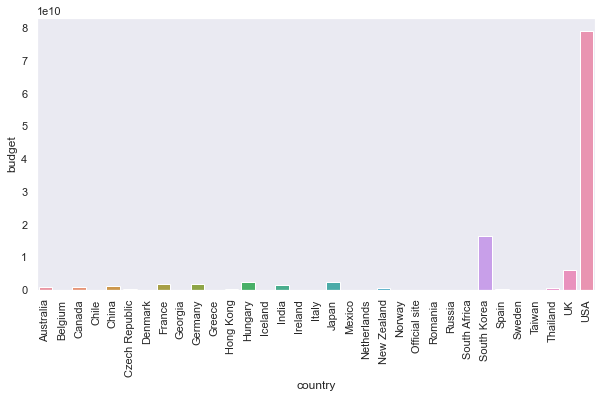

In [24]:
plt.figure(figsize=(10,5))
sns.set(style='dark')
sns.barplot(x=budget_info['country'], y=budget_info['budget'])
plt.xticks(rotation = 90);

Видим тройку лидеров: США, Южная Корея и Великобритания.

Теперь посмотрим, фильмы произведенные в какой стране больше всего собирают в прокате:

In [25]:
gross_info = pd.DataFrame(df_good.groupby(['country'])['gross'].sum()).reset_index()

#gross_info # если нужно посмотреть отдельно dataframe

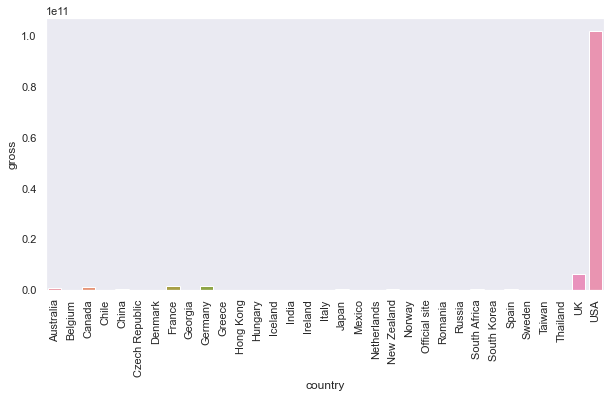

In [26]:
plt.figure(figsize=(10,5))
sns.set(style='dark')
sns.barplot(x=gross_info['country'], y=gross_info['gross'])
plt.xticks(rotation = 90);

Заметим, что из лидеров пропала Корея. Однако это не значит, что снимающиеся в ней дорогостоящие проекты совсем не собирают в прокате. "gross" считается именно по прибыли основного кинорынка мира - США, а если там у корейских фильмов нет сборов, значит отбиваться им приходится в отечественном и мировом прокатах.

Смотря на последний график можно сформировать гипотезу: если в произведенные в США фильмы собирают гораздо больше, чем произведенные в Великобритании, значит люди гораздо охотнее платят за фильмы из США, а значит средняя оценка у фильмов США выше, чем у фильмов Великобритании, ведь люди охотнее платят за хорошие фильмы.

$$
\begin{aligned}
& H_0: \mu_{usa} = \mu_{uk} \\
& H_1: \mu_{usa} > \mu_{uk}
\end{aligned}
$$

Уровень значимости: $5\%$

Проверим гипотезу с помощью z-теста:

In [27]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['country'] == 'USA']['imdb_score'], 
                       df_good.loc[df_good['country'] == 'UK']['imdb_score'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)


(1.64, -5.93)

Наблюдаемое значение -5.93 меньше критического 1.64 -> нулевая гипотеза не отвергается в пользу альтернативной. Мы не можем утверждать, что средняя оценка у фильмов США выше, чем у фильмов Великобритании.

## Поговорим про оценки

Ради этого мы здесь и собрались. Давайте вообще поймем с чем мы имеем дело:

In [28]:
df_good['imdb_score'].describe()

count    1927.000000
mean        6.398599
std         1.042365
min         1.600000
25%         5.800000
50%         6.500000
75%         7.100000
max         9.000000
Name: imdb_score, dtype: float64

Медиана:

In [29]:
df_good['imdb_score'].median()

6.5

Давайте посмотрим на распределение:

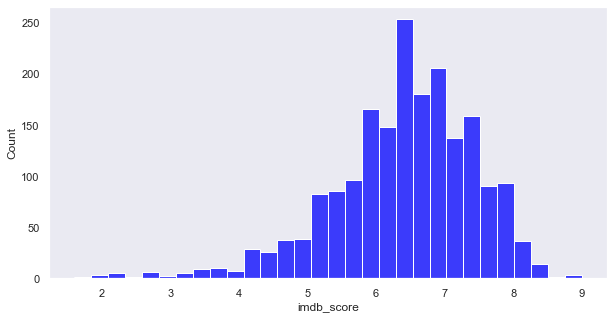

In [30]:
plt.figure(figsize=(10,5))
sns.set(style='dark')
sns.histplot(df_good['imdb_score'], color='blue', bins=30);

Распределение похоже на нормальное, смещенно вправо, есть выбросы. Заметим, что основное количество оценок находится в промежутке от 5 до 8.

Предположим, что хороший фильм получает на imdb оценку 7 или выше (основываясь на имеющихся данных, берем чуть выше среднего и медианы, также берем во внимание информацию здесь: https://thelittlelist.net/is-a-7-good-on-imdb/)

Можем предположить, что хорошие фильмы собирают в прокате в среднем больше, чем остальные фильмы, просто потому что люди любят смотреть хорошие фильмы. 

Сформулируем это в виде гипотезы:$$
\begin{aligned}
& H_0: \mu_{good} = \mu_{bad} \\
& H_1: \mu_{good} > \mu_{bad}
\end{aligned}
$$

Уровень значимости: $5\%$

Проверим выборку на нормальность:

In [31]:
sts.kstest(df_good['gross'], 'norm', args=(df_good['gross'].mean(), df_good['gross'].std(ddof=1)))


KstestResult(statistic=0.21843180771991805, pvalue=3.2927567125670888e-81)

p_value < 0.5 -> гипотеза о нормальности отвергается, можем использовать ассимптотический тест

Проверим гипотезу с помощью z-теста:

In [32]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 7.0]['gross'], 
                       df_good.loc[df_good['imdb_score'] < 7.0]['gross'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 9.28)

Наблюдаемое значение 9.28 больше критического 1.64 -> нулевая гипотеза отвергается в пользу альтернативной. У хороших фильмов сборы в среднем действительно больше, чем у плохих (казалось бы).

Попробуем снизить порог хорошего фильма до оценки 6. Проверим все то же самое:

In [33]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 6.0]['gross'], 
                       df_good.loc[df_good['imdb_score'] < 6.0]['gross'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 6.92)

Наблюдаемое значение 6.92 больше критического 1.64 -> нулевая гипотеза вновь отвергается в пользу альтернативной. У хороших фильмов сборы в среднем снова оказались больше, чем у плохих.

Пробуем повысить до 8:

In [34]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 8.0]['gross'], 
                       df_good.loc[df_good['imdb_score'] < 8.0]['gross'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 10.2)

Получаем идентичный результат, нулевая гипотеза отвергается в пользу альтернативной.

Можем ли мы сказать то же самое о бюджете?

In [35]:
sts.kstest(df_good['budget'], 'norm', args=(df_good['budget'].mean(), df_good['budget'].std(ddof=1)))


KstestResult(statistic=0.4277188895231365, pvalue=1.4367e-320)

p_value < 0.5 -> гипотеза о нормальности отвергается, можем использовать ассимптотический тест

In [36]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 7.0]['budget'], 
                       df_good.loc[df_good['imdb_score'] < 7.0]['budget'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 2.47)

Наблюдаемое значение 2.47 больше критического 1.64 -> нулевая гипотеза отвергается в пользу альтернативной. У хороших фильмов бюджет в среднем больше, чем у плохих.

Так же пробуем понижать оценку до 6:

In [37]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 6.0]['budget'], 
                       df_good.loc[df_good['imdb_score'] < 6.0]['budget'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 1.73)

Наблюдаемое значение 1.73 все еще больше критического 1.64 -> нулевая гипотеза отвергается в пользу альтернативной. Однако наблюдаемое значение уже очень близко к критическому.

Аналагично пробуем повысить до 8:

In [38]:
alpha = 0.05

z_obs, p_value = ztest(df_good.loc[df_good['imdb_score'] >= 8.0]['budget'], 
                       df_good.loc[df_good['imdb_score'] < 8.0]['budget'], 
                       alternative='larger')
z_crit = sts.norm.ppf(1 - alpha)

z_crit.round(2), z_obs.round(2)

(1.64, 0.42)

Неожиданно, наблюдаемое значение 0.42 меньше критического 1.64 -> нулевая гипотеза не отвергается в пользу альтернативной. 

Попробуем t-тест:

In [39]:
_, pval = sts.ttest_ind(df_good.loc[df_good['imdb_score'] >= 8.0]['budget'],
                          df_good.loc[df_good['imdb_score'] < 8.0]['budget'],
                          alternative='greater')

pval

0.3360744343510974

Ожидаемо получаем аналогичный результат. Нулевая гипотеза не отвергается. 

Подведем промежуточные итоги: 

>Вообще в случае сборов (gross) скорее оценка влияет на итоговое значение, тк итоговое число сборов появляется гораздо позже оценки. Она, в свою очередь, будет вносить значительные коррективы в итоговую цифру сборов, меняя мнение потенциальных зрителей о том или иноом фильме. Поэтому некорректно будет относить сборы к факторам, фоомирующим оценку.

>Говоря о бюджете фильма, можно с уверенностью заявить, что оценка по очевидным причинам никак не сможет на него повлиять. Поэтому, если между бюджетом и оценкой существует какая-либо зависимость, она строго односторонняя. Однако, благодаря тестированию гипотез мы увидели, что нужно очень аккуратно выявлять эту зависимость: нельзя просто сказать, что оценка растет вместе с бюджетом - мы убедились, что это не так. Зачастую самые высокие оценки получают достаточно специфичные, концептуальные или просто старые картины далеко не за свои числовые показатели. Ведь кинематограф это все-таки искусство, а в искусстве не приянто восхвалять что-то хорошее, но банальное и закономерное, да и вообще - раньше было лучше.

Примем во внимание эти выводы в дальнейшем.

## Попробуем обучить модель для предсказания оценки

Убираем сильные выбросы

In [40]:
df_1try = df_good.loc[df_good['profitability'] <= 12][['budget', 'profitability', 'imdb_score']]


Разбиваем на выборки 80 к 20

In [41]:
df_train, df_test = train_test_split(df_1try, test_size=0.2, random_state=1443)


Обучаем модель:

In [42]:
y_train = df_train['imdb_score']
y_test = df_test['imdb_score']

X_train = df_train.drop(columns=['imdb_score'], axis=1)
X_test = df_test.drop(columns=['imdb_score'], axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
#y_pred # если нужно посмотреть отдельно


Теперь поглядим на метрики:

In [43]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))

print_metrics(y_test,y_pred)

MAE: 0.8006
RMSE: 1.0608
MAPE: 0.1467


In [44]:
R_squared = model.score(X_train, y_train)
R_squared

0.014413925086692259

Получилось не то что бы ужасно, однако значение R^2 немного удручает, постараемся улучшить результат, включив в обучение больше переменных:

Не секрет, что студии с удовольствием привлекают знаменитых актеров и режиссеров для работы над своими фильмами, чтобы повысить ажиотаж к проекту и тем самым получить больше прибыли. Попробуем реализовать это на практике: 

Считаем несколько заранее подготовленных (уже спарсил) файлов с знаменитыми актерами, актрисами и режиссерами:

In [45]:
data = open('ActorsFile.txt', 'r')
actors_file = data.read().split('\n')
del actors_file[-1]

#actors_file  # если нужно посмотреть отдельно

In [46]:
data_2 = open('ActressesFile.txt', 'r')
actresses_file = data_2.read().split('\n')
del actresses_file[-1]

#actresses_file # если нужно посмотреть отдельно 

In [47]:
data_3 = open('ProducersFile.txt', 'r')
producers_file = data_3.read().split('\n')
del producers_file[-1]

#producers_file # если нужно посмотреть отдельно

Объединим актеров и актрис в один файл:

In [48]:
actors_file.extend(actresses_file)

#actors_file # если нужно посмотреть отдельно

Проведем биномизацию: если актер или режиссер есть в списке - присваеваем 1, иначе 0. Исходная таблица станет выглядеть так:

In [49]:
df_good['actor_1_name'] = np.where(df_good['actor_1_name'].isin(actors_file), 1, 0)
df_good['actor_2_name'] = np.where(df_good['actor_2_name'].isin(actors_file), 1, 0)
df_good['director_name'] = np.where(df_good['director_name'].isin(producers_file), 1, 0)

df_good 

,movie_title,title_year,director_name,actor_1_name,actor_2_name,genres,language,country,budget,gross,imdb_score,duration,content_rating,color,profitability
0,Avatar,2009,0,0,0,Action|Adventure|Fantasy|Sci-Fi,English,USA,237000000,760505847,7.9,178,PG-13,Color,3.208885
1,Pirates of the Caribbean: At World's End,2007,0,1,0,Action|Adventure|Fantasy,English,USA,300000000,309404152,7.1,169,PG-13,Color,1.031347
2,Spectre,2015,0,0,0,Action|Adventure|Thriller,English,UK,245000000,200074175,6.8,148,PG-13,Color,0.816629
3,The Dark Knight Rises,2012,1,0,0,Action|Thriller,English,USA,250000000,448130642,8.5,164,PG-13,Color,1.792523
5,John Carter,2012,0,0,0,Action|Adventure|Sci-Fi,English,USA,263700000,73058679,6.6,132,PG-13,Color,0.277052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,God's Not Dead 2,2016,0,0,0,Drama,English,USA,5000000,20773070,3.4,120,PG,Color,4.154614
4551,The Green Inferno,2013,0,0,0,Adventure|Horror,English,USA,6000000,7186670,5.4,100,R,Color,1.197778
4789,As It Is in Heaven,2004,0,0,0,Comedy|Drama|Music|Romance,Swedish,Sweden,25000000,9910,7.6,133,NaN,Color,0.000396
4804,What Happens in Vegas,2008,0,0,0,Comedy|Romance,English,USA,35000000,80276912,6.1,101,PG-13,Color,2.293626


Новые данные готовы:

In [50]:
df_2try = df_good.loc[df_good['profitability'] <= 12][['budget', 'profitability', 'imdb_score',
                                                       'director_name', 'actor_1_name', 'actor_2_name']]

Обучаем модель:

In [51]:
df_train, df_test = train_test_split(df_2try, test_size=0.2, random_state=1443)

y_train = df_train['imdb_score']
y_test = df_test['imdb_score']

X_train = df_train.drop(columns=['imdb_score'], axis=1)
X_test = df_test.drop(columns=['imdb_score'], axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Смотрим на метрики:

In [52]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))

print_metrics(y_test,y_pred)

MAE: 0.7760
RMSE: 1.0231
MAPE: 0.1424


In [53]:
R_squared = model.score(X_train, y_train)
R_squared

0.0686323742622772

Результаты улучшились, однако не значительно.

Кажется мы совсем забыли про еще один парметр - длительность фильма 'duration', выраженный в минутах. Попробуем добавить его в модель:


Новые данные:

In [54]:
df_3try = df_good.loc[df_good['profitability'] <= 12][['budget', 'profitability', 'imdb_score',
                                                       'director_name', 'actor_1_name', 'actor_2_name', 
                                                       'duration']]

Обучаем модель:

In [55]:
df_train, df_test = train_test_split(df_3try, test_size=0.2, random_state=1443)

y_train = df_train['imdb_score']
y_test = df_test['imdb_score']

X_train = df_train.drop(columns=['imdb_score'], axis=1)
X_test = df_test.drop(columns=['imdb_score'], axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Смотрим на метрки:

In [56]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))

print_metrics(y_test,y_pred)

MAE: 0.7057
RMSE: 0.9496
MAPE: 0.1299


In [57]:
R_squared = model.score(X_train, y_train)
R_squared

0.18855131547562376

Теперь метрики значительно улучшились, и уже наклевывается какой-то вывод, но пропробуем еще одну вещь.

Если вы еще не забыли, в части с провекрой гипотез мы предположили, что включать показатель сборов 'gross' в обучение модели не совсем корректно, тк этот показатель никак не влияет на оценку фильма. Проверим это на практике:

Добавим 'gross' в исходный датафрейм:

In [58]:
df_4try = df_good.loc[df_good['profitability'] <= 12][['budget','gross', 'profitability', 'imdb_score',
                                                       'director_name', 'actor_1_name', 'actor_2_name', 
                                                       'duration']]

Обучим модель:

In [59]:
df_train, df_test = train_test_split(df_4try, test_size=0.2, random_state=1443)

y_train = df_train['imdb_score']
y_test = df_test['imdb_score']

X_train = df_train.drop(columns=['imdb_score'], axis=1)
X_test = df_test.drop(columns=['imdb_score'], axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Посмотрим на метрики:

In [60]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))

print_metrics(y_test,y_pred)

MAE: 0.7131
RMSE: 0.9499
MAPE: 0.1309


In [61]:
R_squared = model.score(X_train, y_train)
R_squared

0.1984151423740198

Видим, что метрики, хоть и не на много, но все же ухудшились, значит наше предположение имеет место быть.

# Выводы:

Как мы увидели, оценка фильмов формируется из множества различных парметров и данных. 

>Первая сложность работы с данными по кинокартинам возникает уже на этапе подготовки данных. Важно корректно отобрать датасет, с которым нужно будет продолжать работать. Однако этому активно препятствуют всевозможные факторы вроде разных годов выпуска, инфляции, мировых кризисов, неожиданно меняющихся жанровых трендов и тд. Поэтому сформировать идеальный датасет в отрыве от внешних факторов практически невозможно.

>Вторая и основная сложность - это сама оценка. Она нередко бывает серьезно изменена в течение времени: например, "Бегущий по лезвию" и "Эквилибриум" - это картины, полностью провалившиеся в прокате, а культовый статус и высокие оценки они получили уже после продажи на носителях, чем и принесли своим создателям основную прибыль (которую,кстати, гораздо труднее подсчитать, по сравнению с прибылью от киноэкранов). Однако решения о продолжении и успехе картины студии вынесли еще во время проката. Здесь и возникает вопрос, какие данные для таких картин стоит брать. К тому же проведя EDA мы выявили большое количество выбросов у различных данных. Из-за их обилия сложно выбросить их все, а они в свою очередь все же искажают реальную картину. 

В любом случае, делая корректировки и небольшие скидки на все эти трудности, благодаря анализу мы увидели, что на оценку влияют настолько разные данные, от режиссера вплоть до продолжительности фильма, что учесть их все, вероятно, невозможно. Однако, стоит отметить, что далеко не все данные помогают предсказать эту неуловимую формулу оценки, важно грамотно интерпретировать имеющиеся данные и выбирать, в каких этапах анализа стоит их использовать.

Используя основные данные о фильмах вроде бюджета и присутствия звездных актеров/режиссеров, модель линейной регрессии показала неплохие результаты, однако, я полагаю, что этот результат можно еще серьезнее улучшить, если подготовить, обработать и передать в модель какие-либо еще неучтенные мной данные о фильмах. 